In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx, from_networkx

In [2]:
dataset = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: CSL(150):
Number of graphs: 150
Number of features: 0
Number of classes: 10
Data(edge_index=[2, 164], y=[1], num_nodes=41)


### Very basic generation of a graphon

This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.

In [3]:
G = to_networkx(data)

In [4]:
# adjaency_matrix = to_dense_adj(data.edge_index).numpy().squeeze()
adjaency_matrix = nx.to_numpy_array(G)
adjaency_matrix

array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.]])

In [5]:
k = 10
clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjaency_matrix)
labels = clustering.labels_

In [6]:
graphon = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        nodes_i = np.where(labels == i)[0]
        nodes_j = np.where(labels == j)[0]
        # print(nodes_i, nodes_j)
        # raise ValueError('TODO: implement this')
        subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
        graphon[i, j] = nx.density(subgraph)

In [65]:
import torch_geometric
import copy
from typing import List, Tuple
from torch_geometric.data import Batch, Data
from torch_geometric.data.collate import collate
from torch_geometric.data.data import BaseData
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.data.separate import separate
from torch_geometric.io import fs
from torch import from_numpy, mean, svd, lt, diag, t

class GMixupDataset():
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation to its base dataset.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        TODO
    """

    def __init__(
        self,
        base_dataset: Dataset,
    ) -> None:
        self.base_dataset = base_dataset
        
        self.generate_graphons()
        
    def generate_graphons(self) -> None:
        self.graphs_by_class = [np.empty(0, dtype=int) for _ in range(self.base_dataset.num_classes)]
        
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(self.graphs_by_class[label], i)
            
        # for i in range(self.base_dataset.num_classes):
        #     print(self.graphs_by_class[i])
            
        self.average_node_count = int(np.mean([data.num_nodes for data in self.base_dataset]))
        # self.average_node_count = 20
        # print(self.average_node_count)
        
        self.graphons = np.zeros((self.base_dataset.num_classes, self.average_node_count, self.average_node_count))
        for i in range(self.base_dataset.num_classes):
            self.graphons[i] = self.generate_graphon(i)
        
        # print(self.graphons)
        return None
    
    def align_graphs(self, graph_adjs:List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray], int, int] :
        num_nodes = [graph_adj.shape[0] for graph_adj in graph_adjs]
        max_num = max(num_nodes)
        min_num = min(num_nodes)

        aligned_adjs = []
        normalized_node_degrees = []
        for graph_adj in graph_adjs :
            curr_n = graph_adj.shape[0]
            node_degree = 0.5 * np.sum(graph_adj, axis=0) + 0.5 * np.sum(graph_adj, axis=1)
            node_degree /= np.sum(node_degree)
            perm = np.argsort(node_degree)  # ascending
            perm = perm[::-1]  # descending

            sorted_node_degree = node_degree[perm]
            sorted_node_degree = sorted_node_degree.reshape(-1, 1)

            sorted_graph = copy.deepcopy(graph_adj)
            sorted_graph = sorted_graph[perm, :]
            sorted_graph = sorted_graph[:, perm]

            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:curr_n, :] = sorted_node_degree
            aligned_adj = np.zeros((max_num, max_num))
            aligned_adj[:curr_n, :curr_n] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_adjs.append(aligned_adj)
        return aligned_adjs, normalized_node_degrees, max_num, min_num

    def generate_graphon(self, class_idx: int, threshold: float = 2.02) -> np.ndarray :
        class_adj_mats = [nx.to_numpy_array(to_networkx(self.base_dataset[graph_index])) 
                          for graph_index in self.graphs_by_class[class_idx]]
        aligned_graphs, normalized_node_degrees, max_num, min_num = self.align_graphs(class_adj_mats)
        graph_tensor_np = np.array(aligned_graphs)
        graph_tensor = from_numpy(graph_tensor_np).float()
        print(f"DEBUG -- {class_idx} graph_tensor = \n{graph_tensor.shape}\n")
        
        # collapse adj mats into 1 matrix
        if graph_tensor.size(0) > 1 :
            agg_graph_adj = mean(graph_tensor, dim=0)
        else :
            agg_graph_adj = graph_tensor[0, :, :]
        print(f"agg_graph_adj = {agg_graph_adj}\n")
        # svd graphon estimation \cite{Chatterjee}
        U, S, V = svd(agg_graph_adj)
        num_nodes = agg_graph_adj.size(0)
        scaled_thresh = threshold * (num_nodes ** 0.5)
        bad_sv_idx = lt(S, scaled_thresh)
        print(f"sv thresh {scaled_thresh}\nbad sv idx {bad_sv_idx}\n")
        print(f"S before {S}\n")
        S[bad_sv_idx] = 0
        print(f"S after {S}\n")
        graphon = U @ diag(S) @ t(V)
        graphon[graphon >= 1] = 1 # clip
        graphon[graphon <= 0] = 0 # clip
        print(f"{graphon}\n\n")
        return graphon.numpy()
    
    def generate_graphon_spectral(self, class_idx: int) -> np.ndarray:
        r"""This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.
        """
        # print(class_idx)
        # print(self.graphs_by_class[class_idx])
        # print()
        final_graphon = np.zeros((self.average_node_count, self.average_node_count))
        
        for graph_index in self.graphs_by_class[class_idx]:
            data = self.base_dataset[graph_index]
            G = to_networkx(data)
            adjaency_matrix = nx.to_numpy_array(G)
            
            clustering = SpectralClustering(n_clusters=self.average_node_count, affinity='precomputed').fit(adjaency_matrix)
            labels = clustering.labels_

            graphon = np.zeros((self.average_node_count, self.average_node_count))
            for i in range(self.average_node_count):
                for j in range(self.average_node_count):
                    nodes_i = np.where(labels == i)[0]
                    nodes_j = np.where(labels == j)[0]
                    subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
                    graphon[i, j] = nx.density(subgraph)
                    
            final_graphon += graphon
            # print(graphon)
        
        final_graphon /= len(self.graphs_by_class[class_idx])
        return final_graphon

    # todo: check how IndexType works
    def generate_graphs(self, idx_1: int, idx_2: int, mixing_param: float, K: int = 10) -> 'Dataset':
        r"""Takes in a batch of graph label pairs and a mixing parameter λ, and returns the new synthetic graph(s) generated using G-Mixup
        """
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2
        
        # print(mixed_graphon)
        
        # K = 10 # number of nodes in output graph
        
        u_values = np.floor(1 / np.random.rand(K))
        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                u_i = int(min(u_values[i], self.average_node_count - 1))
                u_j = int(min(u_values[j], self.average_node_count - 1))
                if np.random.rand() < mixed_graphon[u_i, u_j]:
                    adjacency_matrix[i, j] = 1
                    # adjacency_matrix[j, i] = 1
        print(adjacency_matrix)
                
        graph = nx.from_numpy_array(adjacency_matrix)
        
        return graph
    
    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)

In [ ]:
gmixup_dataset = GMixupDataset(dataset)

In [ ]:
graph = gmixup_dataset.generate_graphs(0, 1, 0.5)
graph_pyg = from_networkx(graph)

In [ ]:
nx.draw(graph, with_labels=True)

In [50]:
mnist = torch_geometric.datasets.MNISTSuperpixels(root="tmp/mnist")


Extracting tmp\mnist\raw\MNISTSuperpixels.zip
Processing...
Done!


In [66]:
gmixup_mnist = GMixupDataset(mnist)

DEBUG -- 0 graph_tensor = 
torch.Size([5923, 75, 75])

agg_graph_adj = tensor([[1.6377e-01, 9.5408e-01, 9.4158e-01,  ..., 1.0130e-03, 5.0650e-04,
         0.0000e+00],
        [9.5408e-01, 1.2207e-01, 9.2453e-01,  ..., 1.5195e-03, 8.4417e-04,
         3.3767e-04],
        [9.4158e-01, 9.2453e-01, 9.4209e-02,  ..., 2.8702e-03, 8.4417e-04,
         1.6883e-04],
        ...,
        [1.0130e-03, 1.5195e-03, 2.8702e-03,  ..., 3.3429e-02, 6.6689e-02,
         1.1278e-01],
        [5.0650e-04, 8.4417e-04, 8.4417e-04,  ..., 6.6689e-02, 2.3468e-02,
         5.1157e-02],
        [0.0000e+00, 3.3767e-04, 1.6883e-04,  ..., 1.1278e-01, 5.1157e-02,
         1.3507e-02]])

sv thresh 17.49371315644566
bad sv idx tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  T

In [67]:
gmixup_mnist.graphs_by_class[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

[[0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 0. 0.]]
DiGraph with 75 nodes and 1260 edges
Drawing Real Label 0 graph...
Drawing Generated Label 0 graph...


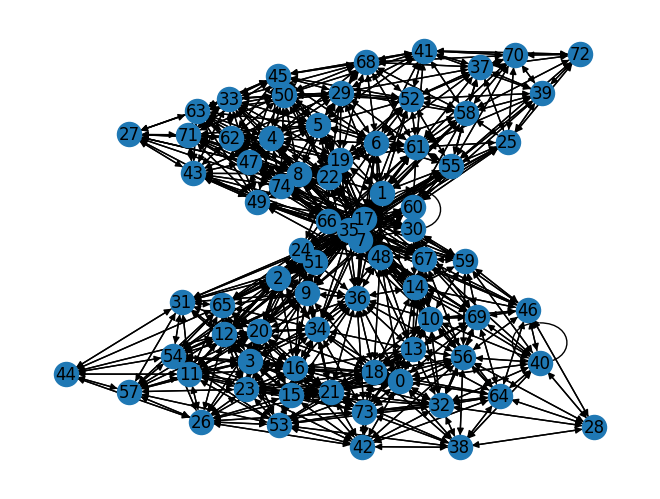

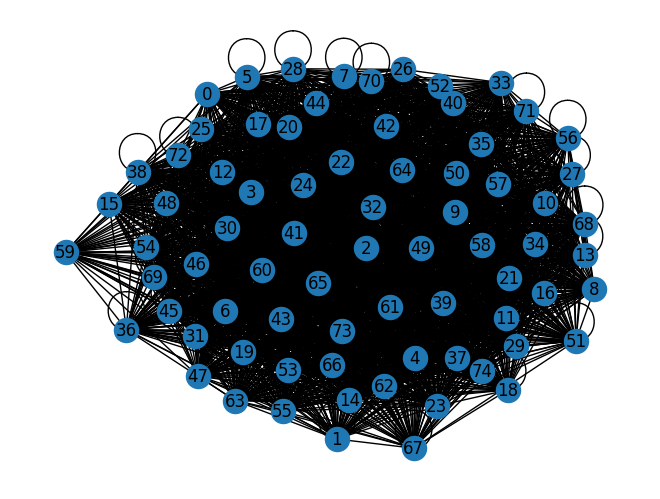

In [68]:
graph_real = to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][0]])
graph_gen = gmixup_mnist.generate_graphs(0, 1, 1, K=75)

import matplotlib.pyplot as plt
print(graph_real)
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)